# 1.この課題の目的
- スクラッチを通してCNNの基礎を理解する
- 基本的なCNNのキーワードを学習する
- 初期の有名なCNNモデルを知る

# 2.スクラッチによる実装
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

Sprint12では1次元畳み込み層を実装しましたが、Sprint13では画像に対して一般的に使われる2次元畳み込み層を実装します。また、プーリング層なども作成することで、CNNの基本形を完成させます。

## データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。

今回は白黒画像であるからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。

(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

## CNN分類器クラスの作成
2次元畳み込みニューラルネットワークモデルのクラスScratch2dCNNClassifierを作成してください。

## CNN分類器クラスの作成

2次元畳み込みニューラルネットワークモデルのクラスScratch2dCNNClassifierを作成してください。

## 【問題1】2次元畳み込み層の作成

Sprint12で作成した1次元畳み込み層を発展させ、2次元畳み込み層のクラスConv2dを作成してください。

## 【問題1】2次元畳み込み層の作成

Sprint12で作成した1次元畳み込み層を発展させ、2次元畳み込み層のクラスConv2dを作成してください。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値

$i$  : 配列の行方向のインデックス

$j$ : 配列の列方向のインデックス

$m$ : 出力チャンネルのインデックス

$K$ : 入力チャンネル数

$F_h,F_w$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ

$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値

$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み

$b_m$ : mチャンネルへの出力のバイアス項

全てスカラーです。

次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}}$$

$$b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}$$

$\alpha$ : 学習率

$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配

勾配$\frac{\partial L}{\partial w_{s,t,k,m}}$や$\frac{\partial L}{\partial b_{m}}$を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}
$$

$$
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値

$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ

前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値

$M$ : 出力チャンネル数

ただし、$i-s<0$または$i-s>N_{out,h}-1$または$j-t<0$または$j-t>N_{out,w}-1$のとき$\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$です。

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import copy
from collections import OrderedDict
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [4]:
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) 
print(X_val.shape)

(48000, 1, 28, 28)
(12000, 1, 28, 28)


## Conv2dクラス

In [6]:
class Conv2d:
    """
    2次元畳み込み層クラス
    
    Parameters
    --------------
     filter_num : int
         フィルタの数
     channel_num : int
         チャンネル数
     filter_size : int
         フィルタの大きさ(縦横同じ)
     initializer : インスタンス
         重みの初期化方法
     optimizer : インスタンス
         最適化手法
     stride : int
         ストライド数
     pad : int
        パディング数    

    Attributes
    -------------
    W : numpy配列
        フィルタ
    B : numpy配列
        バイアス
    forward_input : numpy配列
        入力データのコピー
    col : im2colの出力
    col_W : 展開後のフィルタ

    dif_W : numpy配列
        Wの微分
    dif_B : numpy配列
        Bの微分
    """
    def __init__(self, filter_num, channel_num, filter_size, initializer, optimizer, stride, pad):
        self.filter_num = filter_num
        self.channel_num = channel_num
        self.filter_size = filter_size
        
        self.initializer = initializer
        self.optimizer = optimizer
        
        self.stride = stride
        self.pad = pad
        
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self)
        self.B = self.initializer.B(self)
        
        #インスタンス変数
        self.forward_input = None
        self.col = None
        self.col_W = None
        self.dif_W = None
        self.dif_B = None
        
        
    def forward(self, forward_input):
        """
        フォワード
        
        Parameters
        ----------
        forward_input : numpy配列
            順伝搬の入力
            
        Returns
        ---------
        forward_output : numpy配列
            順伝搬の出力
        """
        
        self.forward_input = forward_input
        
        FN, C, FH, FW = self.W.shape #フィルター
        N, C, H, W = forward_input.shape #サンプル
        
        #出力サイズ
        out_h, out_w = self.compute_output_size(H, FH, W, FW)
        
        #im2col
        self.col = self.im2col()
        
        #フィルタを展開
        self.col_W = self.W.reshape(FN, -1).T

        forward_output = np.dot(self.col, self.col_W) + self.B
        forward_output = forward_output.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) 

        return forward_output


    def backward(self, backward_input):
        """
        Parameters
        --------------
        backward_input : numpy配列
            逆伝搬の入力
        
        Returns
        ---------
        backward_output : numpy配列
            逆伝搬の出力
        """        
        
        FN, C, FH, FW = self.W.shape
        
        backward_input = backward_input.transpose(0,2,3,1).reshape(-1, FN) 
        
        #逆伝播
        self.dif_B = np.sum(backward_input, axis=0)
        self.dif_W = np.dot(self.col.T, backward_input)
        self.dif_W = self.dif_W.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = np.dot(backward_input, self.col_W.T)
        
        #col2im
        backward_output = self.col2im(dcol)
        
        # 更新
        self = self.optimizer.update(self)        

        return backward_output
    
    
    def im2col(self):
        """
        Parameters
        ----------
            
        Returns
        -------
        col : numpy配列
            im2colの出力
        """
        N, C, H, W = self.forward_input.shape
        
        _, _, FH, FW = self.W.shape
        
        #出力されるサイズ
        out_h, out_w = self.compute_output_size(H, FH, W, FW)

        #パディング
        img = np.pad(self.forward_input, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        
        col = np.zeros((N, C, FH, FW, out_h, out_w))
        for y in range(FH):
            y_max = y + self.stride * out_h
            for x in range(FW):
                x_max = x + self.stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y: y_max: self.stride, x: x_max: self.stride]
        
        #形を整える
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)

        return col
    
    
    def col2im(self, dcol):
        """
        Parameters
        ----------
        dcol : Xに関する損失Lの勾配
        
        Returns
        ----------
        img[:, :, self.pad: H + self.pad, self.pad: W + self.pad] : numpy配列
            col2imの出力
        """
        
        N, C, H, W = self.forward_input.shape
        _, _, FH, FW = self.W.shape #フィルター

        out_h, out_w = self.compute_output_size(H, FH, W, FW)
        
        dcol = dcol.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)
        
        img = np.zeros((N, C, H + 2 * self.pad + self.stride - 1, W + 2 * self.pad + self.stride - 1))
        for y in range(FH):
            y_max = y + self.stride * out_h
            for x in range(FW):
                x_max = x + self.stride * out_w
                img[:, :, y: y_max: self.stride, x: x_max: self.stride] += dcol[:, :, y, x, :, :]

        return img[:, :, self.pad: H + self.pad, self.pad: W + self.pad]
    
    
    def compute_output_size(self, H, FH, W, FW):
        '''
        出力サイズを計算する関数
        
        Parameters
        --------------
        H : int
            入力データの高さ
        FH : int
            フィルターの高さ
        W : int
            入力データの幅
        FW : int
            フィルターの幅
            
        Returns
        ----------
        out_h : int
            出力データの高さ
        out_w : int
            出力データの幅
        '''
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        return out_h, out_w

## 【問題2】2次元畳み込み後の出力サイズ

畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$ N_{h, out} = \frac{N_{h, in} + 2P_{h} - F_{h}}{S_{h}} + 1$$

$$ N_{w, out} = \frac{N_{w, in} + 2P_{w} - F_{w}}{S_{w}} + 1$$

$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

$h$ が高さ方向、 $w$ が幅方向である

## compute_output_sizeクラス

In [7]:
def compute_output_size(NH, NW, FH, FW, PH, PW, SH, SW):
        """
        畳み込み層の出力サイズを計算
        Parameters
        ----------
        NH :  int
            入力データの行数
        HW :  int
            入力データの列数
        FH :  int
            フィルタの行数
        FW :  int
            フィルタの列数
        PH :  int
            パディングの高さ
        PW :  int
            パディングの横
        SH :  int
            ストライド(高さ)
        SW :  int
            ストライド(横)

        Returns
        -------
        NH_out : int
            出力サイズの行数
        NW_out : int
            出力サイズの列数
        """
        out_H = (NH + 2 * PH - FH)//SH + 1
        out_W = (NW + 2 * PW - FW)//SW + 1
        
        return out_H, out_W

## 【問題3】最大プーリング層の作成

最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_h \times S_w$ の範囲内の行（p）と列（q）

$S_h,S_w$  : 高さ方向（h）と幅方向（w）のストライドのサイズ

$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス

$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値

$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。

バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス 
$(p,q)$ を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

## MaxPool2Dクラス

In [8]:
class MaxPool2D:
    '''
    2次元畳み込み層クラス
    Parameters
    --------------
     pool_h : int
         プーリングを行うエリアの高さ
     pool_w : int
         プーリングを行うエリアの幅
     stride : int
         ストライド
     pad : int
        パディング    

    Attributes
    -------------
    forward_input : numpy配列
        順伝搬の入力
    arg_max : numpy配列
        プーリング時に使用するデータ
        
    '''
    def __init__(self, pool_h, pool_w, stride, pad):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.forward_input = None
        self.arg_max = None

    def forward(self, forward_input):
        """
        フォワード
        
        Parameters
        ----------
        forward_input : numpy配列
            順伝搬の入力
            
        Returns
        -------
        out : 
            maxプーリングした結果

        """
        self.forward_input = forward_input
        
        N, C, H, W = forward_input.shape
        
        out_h, out_w = self._out_shape(H, self.pool_h, W, self.pool_w)
        
        #im2col
        col = self._im2col(forward_input, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        #pooling
        arg_max = np.argmax(col, axis=1)
        self.arg_max = arg_max
        out = np.max(col, axis=1)
        
        forward_output = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return forward_output

    
    def backward(self, backward_input):
        """
        Parameters
        ----------
        backward_input : numpy配列
            逆伝搬の入力
        
        Returns
        -------
        backward_output : numpy配列
            逆伝搬の出力
        """        
        backward_input = backward_input.transpose(0, 2, 3, 1)
        
        #col2im
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((backward_input.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(backward_input.shape + (pool_size,)) 
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        backward_output = self._col2im(dcol, self.forward_input.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return backward_output

    
    def _im2col(self, input_data, FH, FW, stride, pad):
        """
        Parameters
        ----------
        input_data : numpy配列
            入力データ
        FH : int
            フィルターの高さ
        FW : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
        
        Returns
        -------
        col : numpy配列
            im2colの出力
        """
        N, C, H, W = input_data.shape
        
        #出力されるサイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)

        #パディング
        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        
        col = np.zeros((N, C, FH, FW, out_h, out_w))
        for y in range(FH):
            y_max = y + stride * out_h
            for x in range(FW):
                x_max = x + stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y: y_max: stride, x: x_max: stride]

        #形を整える
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1) 

        return col
    
    
    def _col2im(self, col, input_shape, FH, FW, stride, pad):
        """
        Parameters
        ----------
        col : 
            
        input_shape : 
            入力データの形状（例：(10, 1, 28, 28)）
        FH : int
            フィルターの高さ
        FW : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
        
        Returns
        ---------
        col2imの結果
        """
        N, C, H, W = input_shape

        #出力サイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)
        
        #reshape、位置変換
        col = col.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2) 

        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(FH):
            y_max = y + stride*out_h
            for x in range(FW):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
    
    
    def _out_shape(self, H, FH, W, FW):
        '''
        出力サイズを計算する関数

        Parameters
        --------------
        H : int
            高さ
        FH : int
            フィルターの高さ
        W : int
            幅
        FW : int
            フィルターの幅

        Returns
        ----------
        out_h : int
            出力データの高さ
        out_w : int
            出力データの幅
        '''
        out_h = 1 + int((H - FH) / self.stride)
        out_w = 1 + int((W- FW) / self.stride)
        
        return out_h, out_w

## 【問題4】平滑化

平滑化するためのクラスFlatten()を作成してください。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

## Flattenクラス

In [11]:
class Flatten():
    '''
    平滑化を実施
    
    Attribute
    -----------
    forward_input_shape : numpy配列
        順伝搬のデータのshape
    '''
    def __init__(self):
        self.forward_input_shape = None
    
    
    def forward(self, forward_input):
        '''
        フォワード

        Parameters
        -------------
        forward_input : numpy配列
            順伝搬の入力
            
        Returns
        ----------
        forward_output : numpy配列
            順伝搬の出力
        '''
        #1次元にする
        forward_output = forward_input.reshape(forward_input.shape[0], -1)
        
        #shapeを記録
        self.forward_input_shape = forward_input.shape
        
        return forward_output
    

    def backward(self, backward_input):
        '''
        バックワード

        Parameters
        -------------
        backward_input : numpy配列
            逆伝搬の入力
            
        Returns
        ----------
        backward_input : numpy配列
            逆伝搬の出力
        '''
        #shapeを戻す
        backward_output = backward_input.reshape(self.forward_input_shape)
        
        return backward_output

## 【問題5】学習・推定

作成したConv2dを使用してMNISTの分類を学習・推定してください。

この段階では精度は気にせず、動くことを確認してください。

## ScratchDeepNeuralNetrowkClassifierクラス

In [12]:
class ScratchConv2DNeuralNetrowkClassifier():
    
    """
    シンプルなCNN分類器

    Parameters
    ----------
    lr :　float
        学習率
    sigma　：　float
        ガウス分布の標準偏差
    batch_size : int
        バッチサイズ
    n_epochs : int
        エポック数
    conv_params : タプル
        Conv層の情報
    pool_params : タプル
        pool層の情報
    hidden_size : int
        隠れ層の数
    n_output : int
        出力のクラス数（3層目のノード数）
    initilizer : インスタンス
        初期化方法のクラスのインスタンス
    activater : インスタンス
        活性化関数のクラスのインスタンス
    optimizer : インスタンス
        最適化方法のインスタンス
    verbose : bool
        学習結果を表示するかを設定するフラグ
    
    Attributes
    ----------
    filter_channel : int
        フィルターのチャンネル数
    filter_num : int
        フィルターの数
    filter_size : int
        フィルターのサイズ
    stride : int
        ストライド
    pad : int
        パディング
        
    pool_H : int
        プーリングを行うエリアの高さ
    pool_W : int
        プーリングを行うエリアの高さ
    pool_stride : int
        プーリングを行うエリアの高さ
    pool_pad : int
        プーリングを行うエリアの高さ
        
    hidden_size : int
        隠れ層の数
    n_output : int
        出力サイズ
        
    self.loss_list : list
        エポック毎の学習用データに対するロスを格納しているリスト
    self.val_loss_list : list
        エポック毎の検証用データに対するロスを格納しているリスト
    self.verification_flag : bool
        検証用データの有無を設定するフラグ
    self.layers : OrderdDict
        各層のインスタンスを格納する辞書
    """

    def __init__(self,lr, sigma, batch_size, n_epochs, conv_params, pool_params,\
                 hidden_size, n_output, initializer, activater, optimizer, verbose=None):

        self.lr = lr
        self.sigma = sigma
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        
        self.filter_channel = conv_params['filter_channel']
        self.filter_num = conv_params['filter_num']
        self.filter_size = conv_params['filter_size']
        self.stride = conv_params['stride']
        self.pad = conv_params['pad']
        
        self.pool_H = pool_params['H']
        self.pool_W = pool_params['W']
        self.pool_stride = pool_params['stride']
        self.pool_pad = pool_params['pad']
        
        self.hidden_size = hidden_size
        self.n_output = n_output
        
        self.verbose = verbose
        
        
        # 損失を記録する配列を用意
        self.loss_list = []
        self.val_loss_list = []
        self.verification_flag = None

        FC_init_dict = {'Sim' : SimpleInitializer(sigma=self.sigma, model_name='FC'),\
                        'Xa' : XavierInitializer(model_name='FC'),\
                        'He' : HeInitializer(model_name='FC')}
        
        Conv_init_dict = {'Sim' : SimpleInitializer(sigma=self.sigma, model_name='Conv'),\
                          'Xa' : XavierInitializer(model_name='Conv'),\
                          'He' : HeInitializer(model_name='Conv')}
        
        
        act_dict = {'Sig' : Sigmoid(),\
                    'Relu' : Relu(),\
                    'Tanh' : Tanh()}
        
        
        opt_dict = {'SGD' : SGD(lr=self.lr),\
                    'AdaGrad' : AdaGrad(lr=self.lr)}
        
        FC_init = FC_init_dict[initializer]
        Conv_init = Conv_init_dict[initializer]
        act = act_dict[activater]
        opt = opt_dict[optimizer]
        
        # OrderedDictに各層のインスタンスを格納する
        self.layers = OrderedDict()

        self.layers['Conv1'] = Conv2d(filter_num=self.filter_num,\
                                      channel_num = self.filter_channel,\
                                      filter_size=self.filter_size,\
                                      initializer=copy.deepcopy(Conv_init),\
                                      optimizer=copy.deepcopy(opt),\
                                      stride=self.stride,\
                                      pad=self.pad)
        
        self.layers['Act1'] = copy.deepcopy(act)
        self.layers['Pool1'] = MaxPool2D(pool_h=self.pool_H,\
                                         pool_w=self.pool_W,\
                                         stride=self.pool_stride,\
                                         pad=self.pool_pad)
        self.layers['Flat'] = Flatten()
        
        
        self.layers['FC1'] = FC(n_nodes2 = hidden_size,\
                                initializer=copy.deepcopy(FC_init),\
                                optimizer=copy.deepcopy(opt))
        self.layers['Act4'] = copy.deepcopy(act)
        
        
        self.layers['FC2'] = FC(n_nodes2=self.n_output,\
                                initializer=copy.deepcopy(FC_init),\
                                optimizer=copy.deepcopy(opt))
        self.layers['Last_layer'] = Softmax_withloss()
        
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X_train : numpy配列
            学習用データの特徴データ
        y_train : numpy配列
            学習用データの正解データ
        X_val : numpy配列
            検証用データの特徴データ
        y_val : numpy配列
            検証用データの正解データ
        """
        # 検証データの有無を記録するフラグ
        if X_val is not None and y_val is not None:
            self.verification_flag = True
        
        # OneHotEncoding
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
        
        # 検証用データの有無を確認し、self.verification_flagを更新
        if self.verification_flag:
            y_val_one_hot = enc.transform(y_val[:, np.newaxis])
        
        """
        ミニバッチ処理開始
        """
        #ミニバッチ処理を行うインスタンスを作成

        for e in range(self.n_epochs):
            get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=self.batch_size)
            
            # バッチサイズ毎にデータを取得し、順伝搬、逆伝搬を行い重みとバイアス項を更新する
            for mini_X_train, mini_y_train in get_mini_batch_train:
                _ = self.forward(mini_X_train)
                self.backward(mini_y_train)

            # 学習用データとのロスを計算しリストに格納
            train_loss = self.loss(X_train, y_train_one_hot)
            self.loss_list.append(train_loss)

            # 検証用データの有無を判別→データが存在する場合、検証用データとのロスを計算しリストに格納
            if self.verification_flag:
                val_loss = self.loss(X_val, y_val_one_hot)
                self.val_loss_list.append(val_loss)

                
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print('{}epoch目\n'.format(e + 1))
                print('学習用正解データとの誤差　：　{:.4f}\n'.format(train_loss))

                if self.verification_flag:
                    print('検証用正解データとの誤差　：　{:.4f}\n'.format(val_loss))
                print('------------------------------------------------')


    def predict(self, test_data):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        test_data : numpy配列
            テストデータ

        Returns
        -------
        y_pred : numpy配列
            推定結果
        """
        # 順伝搬の出力(最後の層はsoftmaxなので、各クラスの予測確率)を計算
        forward_output = self.forward(test_data)
        
        # 最も高い値のindexを出力する
        y_pred = np.argmax(forward_output, axis=1)
        
        return y_pred

    
    # 順伝搬
    def forward(self, input_data):
        """
        順伝搬

        Parameters
        ----------
        input_data : numpy配列
            入力データ

        Returns
        -------
        forward_output : numpy配列
            順伝搬の出力
        """
        forward_output = input_data
        
        # 順伝搬の出力の計算
        # 各層を順にlayerに格納し順伝搬の計算を行い、出力結果を次の層のforwardメソッドに入力していく
        for layer in self.layers.values():
            forward_output = layer.forward(forward_output)

        return forward_output
        
    
    # 誤差逆伝搬
    def backward(self,teacher_data):
        """
        逆伝搬

        Parameters
        ----------
        teacher_data : numpy配列
            入力データ
        """
        backward = teacher_data
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            backward = layer.backward(backward)

            
            
    def loss(self, input_data, teacher_data):
        """
        ロスを計算

        Parameters
        ----------
        input_data : numpy配列
            入力データ
        teacher_data : numpy配列
            正解データ

        Returns
        -------
        loss_per_batch_size : numpy配列
            １データ毎のクロスエントロピー誤差
        """
        forward_output = self.forward(input_data)
        loss_per_batch_size = self.layers['Last_layer'].cross_entropy_error(teacher_data)
        
        return loss_per_batch_size
        

    def plot_learning_curve(self):
        """
        学習曲線を表示(学習データに対してのロス・検証データに対してのロス)
        """
        plt.plot(range(self.n_epochs), self.loss_list, label='loss')
        plt.plot(range(self.n_epochs), self.val_loss_list, label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('mse')
        plt.title('Learning curve')
        plt.legend()
        return

## GetMiniBatchクラス

In [14]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

## FCクラス

In [15]:
class FC:
    """
    FC層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : インスタンス
        初期化方法のクラスのインスタンス
    optimizer : インスタンス
        最適化手法のクラスのインスタンス
        
    Attributes
    ----------
    forward_input : numpy配列
        順伝搬の入力
    dif_B ; numpy配列
        バイアスの微分
    dif_W : numpy配列
        重みの微分
    first_forward : bool
        最初の順伝搬かどうかを確認するためのフラグ
    
    """
    def __init__(self, n_nodes2, initializer, optimizer):
        self.n_nodes1 = None
        self.n_nodes2 = n_nodes2
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = None
        self.B = None
        
        self.initializer = initializer
        self.optimizer = optimizer #最適化手法
        
        self.forward_input = None
        self.dif_B = None
        self.dif_W = None
        
        self.first_forward = True

    
    def forward(self, forward_input):
        """
        フォワードプロバケーション
        Parameters
        ----------
        forward_input : 次の形のnbackward_inputrray, shape (batch_size, n_nodes1)
            入力
            
        Returns
        ----------
        Z2 : 次の形のnbackward_inputrray, shape (batch_size, n_nodes2)
            出力
        """
        
        # 最初の順伝搬の時は入力データのshapeからself.Wとself.Bを初期化する
        if self.first_forward == True:
            self.first_forward = False
            self.n_nodes1 = forward_input.shape[1]
            self.W = self.initializer.W(self)
            self.B = self.initializer.B(self)

        self.forward_input = forward_input.copy()
        
        #順伝搬の計算
        forward_output = self.forward_input @ self.W + self.B
        
        return forward_output
    
    
    def backward(self, backward_input):
        """
        バックプロバケーション
        Parameters
        ----------
        backward_input : 次の形のnbackward_inputrray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
            
        Returns
        ----------
        dZ : 次の形のnbackward_inputrray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        #バイアスの微分
        self.dif_B = backward_input
        #重みの微分
        self.dif_W = self.forward_input.T @ backward_input
        #逆伝搬の出力
        backward_output = backward_input @ self.W.T 
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        
        return backward_output

## SimpleInitializerクラス

In [16]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
        ガウス分布の標準偏差
    model_name : string
        初期化する層を決める文字列
    """
    def __init__(self, sigma, model_name):
        self.sigma = sigma
        self.model_name = model_name
        

    def W(self, layer):
        """
        重みの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        W : numpy配列
            重み
        """
        
        #FC層の初期化
        if self.model_name == 'FC':
            W =  self.sigma * np.random.randn(layer.n_nodes1, layer.n_nodes2) 
            
        #Conv層の初期化
        if self.model_name == 'Conv':
            W =  self.sigma * np.random.randn(layer.filter_num, layer.channel_num, layer.filter_size, layer.filter_size) 

        return W
    
    
    def B(self, layer):
        """
        バイアスの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        B :numpy配列
            バイアス
        """
        #FC層の初期化
        if self.model_name == 'FC':
            B = np.zeros(layer.n_nodes2)
            
        #Conv層の初期化
        if self.model_name == 'Conv':
            B = np.zeros(layer.filter_num)
        
        return B

## XavierInitializerクラス

In [17]:
class XavierInitializer:
    """
    Xavierの初期値のクラス
    Parameters
    ----------
    model_name : string
        初期化する層を決める文字列
    """
    def __init__(self, model_name):
        self.model_name = model_name
        

    def W(self, layer):
        """
        重みの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        W : numpy配列
            重み
        """
        
        #全結合層
        if self.model_name == 'FC':
            W = np.random.randn(layer.n_nodes1, layer.n_nodes2) / np.sqrt(layer.n_nodes1) 
        #畳み込み層
        if self.model_name == 'Conv':
            W =  np.random.randn(layer.filter_num, layer.channel_num, layer.filter_size, layer.filter_size) / np.sqrt(layer.filter_num) 
        

    
        return W
    
    
    def B(self, layer):
       """
        バイアスの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        B :numpy配列
            バイアス
        """
        if self.model_name == 'FC':
            B = np.zeros(layer.n_nodes2) 
            
        if self.model_name == 'Conv':
            B = np.zeros(layer.filter_num)
        
        return B

## HeInitializerクラス

In [18]:
class HeInitializer:
        """
        Heの初期値のクラス
        Parameters
        ----------
        model_name : string
            初期化する層を決める文字列
        """
    def __init__(self, model_name):
        self.model_name = model_name
        
        """
        重みの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        W : numpy配列
            重み
        """
        
        #全結合層
        if self.model_name == 'FC':
            W = np.random.randn(layer.n_nodes1, layer.n_nodes2) * np.sqrt(2 / layer.n_nodes1)
        
        #畳み込み層
        if self.model_name == 'Conv':
            W = np.random.randn(layer.filter_num, layer.Channel_num, layer.filter_size, layer.filter_size) * np.sqrt(2 / layer.filter_num)
       

    
        return W
    
    
    def B(self, layer):
       """
        バイアスの初期化
        Parameters
        ----------
        layer : インスタンス
            各層のインスタンス

        Returns
        ----------
        B :numpy配列
            バイアス
        """
        
        if self.model_name == 'FC':
            B = np.zeros(layer.n_nodes2) 
        
        if self.model_name == 'Conv':
            B = np.zeros(layer.filter_num)
        
        return B

## SGDクラス

In [19]:
class SGD:
        """
        SGD
        Parameters
        ----------
        lr : float
            学習率
        """
    def __init__(self, lr):
        self.lr = lr #学習率

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        #バッチサイズで割る
        layer.W -= self.lr* layer.dif_W / layer.dif_B.shape[0] #(n_nodes1, n_nodes2)
        layer.B -= self.lr* layer.dif_B.mean(axis=0) #(n_nodes2)
        
        return layer

## AdaGradクラス

In [20]:
class AdaGrad:
        """
        AdaGrad
        Parameters
        ----------
        lr : 学習率

        Attributes
        -------------
        h_W : ndarray
            前のイテレーションまでの重みの勾配の二乗和
        h_B : ndarray
            前のイテレーションまでのバイアスの勾配の二乗和
        """
    def __init__(self, lr):
        #ハイパーパラメータ
        self.lr = lr #学習率
        
        #インスタンス変数
        self.h_W= None #重みの勾配の二乗和の配列
        self.h_B = None #バイアスの勾配の二乗和の配列
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        #self.Hの初期化
        if self.h_W is None:
            self.h_W = np.zeros(layer.W.shape)
        if self.h_B is None:
            self.h_B = np.zeros(layer.B.shape)
        
        #更新    
        self.h_W += (layer.dif_W / layer.dif_B.shape[0]) ** 2 #重みの勾配の二乗和
        self.h_B += (layer.dif_B.mean(axis=0)) ** 2 #バイアスの二乗和
        layer.W -= self.lr / np.sqrt(self.h_W + 1e-7) * layer.dif_W / layer.dif_B.shape[0] #重み
        layer.B -= self.lr / np.sqrt(self.h_B + 1e-7) * layer.dif_B.mean(axis=0) #バイアス 
        
        return layer

## Sigmoidクラス

In [21]:
class Sigmoid:
        '''
        シグモイド関数のクラス
        Attributes
        --------------
        forward_output : numpy配列
            順伝搬の出力
        '''
    def __init__(self):
        self.forward_output = None
    

    def forward(self, A):
        '''
        順伝搬
        Parameters
        --------------
        A : numpy配列
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        forward_output : numpy配列
            順伝搬の出力
        '''
        self.forward_output = 1 / (1 + np.exp(-A)) 
        
        return self.forward_output
    
    
    def backward(self, backward_input):
        '''
        逆伝搬
        Parameters
        --------------
        dackward_input : numpy配列
            逆伝搬の入力
        
        Returns
        ---------
        backward_output : numpy配列
            逆伝搬の出力
        '''
        backward_output = backward_input * (1 - self.forward_output) * self.forward_output
        
        return backward_output

## Tanhクラス

In [22]:
class Tanh:
        '''
        ハイパポリックタンジェント関数のクラス
        Attributes
        --------------
        forward_output : numpy配列
            順伝搬の入力
        '''
    def __init__(self):
        self.forward_output = None

    
    def forward(self, forward_input):
        '''
        順伝搬
        Parameters
        --------------
        forward_input : numpy配列
            順伝搬の入力
        
        Returns
        ---------
        forward_output : numpy配列
            逆伝搬の出力
        '''
        self.forward_output =  np.tanh(forward_input)
        
        return  self.forward_output
    
    
    def backward(self, backward_input):
        '''
        逆伝搬
        Parameters
        --------------
        backward_input : numpy配列
            逆伝搬のの入力
        
        Returns
        ---------
        backward_output : numpy配列
            逆伝搬の出力
        '''
        backward_output = backward_input * (1 - self.forward_output**2)
        
        return backward_output

## Reluクラス

In [23]:
class Relu:
    '''
    ReLU関数のクラス
    Attributes
    --------------
    forward_output : numpy配列
        順伝搬の入力
    '''
    def __init__(self):
        self.forward_input = None #特徴量ベクトルと重みとバイアスを計算した配列

    
    def forward(self, forward_input):
        '''
        順伝搬
        Parameters
        --------------
        forward_input : numpy配列
            順伝搬の入力
        
        Returns
        ---------
        forward_output : numpy配列
            順伝搬の出力
        '''
#         print('Reluクラス_forward開始')
        self.forward_input = forward_input.copy()
        
        #Aが0以下なら0にする
        forward_output = np.maximum(0, forward_input)
        
#         print('forward_output.shape = {}'.format(forward_output.shape))
        return forward_output
    
    
    def backward(self, backward_input):
        '''
        逆伝搬
        Parameters
        --------------
        backward_input : numpy配列
            逆伝搬のの入力
        
        Returns
        ---------
        backward_output : numpy配列
            逆伝搬の出力
        '''
        #forwardで0以下の部分を0にする
        backward_output = np.where(self.forward_input > 0, backward_input, 0)

        return backward_output

## Softmaxクラス

In [24]:
class Softmax_withloss():
    
    def __init__(self):
        """
        ソフトマックス関数とロス関数を計算

        atribute
        ----------
        self.forward_output : numpy配列
            順伝搬の出力
        self.batch_size : int
            バッチサイズ
        """
        
        self.forward_output = None
        self.batch_size = None
    
    def forward(self, FC_output):
        """
        順伝搬
        Parameters
        ----------
        FC_output : numpy配列
            FC層の順伝搬時の出力データ

        Returns
        ----------
        self.forward_output : numpy配列
            順伝搬の出力データ
        """
        self.forward_output = self.softmax(FC_output)
        return self.forward_output
    
    def backward(self, teacher_data):
        """
        逆伝搬
        Parameters
        ----------
        teacher_data : numpy配列
            正解データ

        Returns
        ----------
        backward_output : numpy配列
            逆伝搬の出力データ
        """
        backward_output = self.forward_output - teacher_data
        return backward_output
    
    def softmax(self, FC_output):
        """
        ソフトマックス関数を計算
        Parameters
        ----------
        FC_output : FC層の順伝搬時の出力データ
            正解データ

        Returns
        ----------
        softmax_output : numpy配列
            ソフトマックス関数の出力
        """
        # 最大値を取得
        FC_output_max = np.max(FC_output, axis=1)
        # オーバーフロー対策の為、各値から最大値を引く
        exp_FC_output = np.exp(FC_output - FC_output_max.reshape(-1, 1))
        sum_exp_FC_output = np.sum(exp_FC_output, axis=1).reshape(-1, 1)
        # ソフトマックス関数を計算
        softmax_output = exp_FC_output / sum_exp_FC_output
        
        return softmax_output
    
    def cross_entropy_error(self, teacher_data):
        """
        クロスエントロピー誤差を計算
        Parameters
        ----------
        teacher_data : numpy配列
            正解データ

        Returns
        ----------
        loss_per_batch_size : numpy配列
            １データ毎のクロスエントロピー誤差
        """
        # クロスエントロピー誤差を計算
        loss = teacher_data * (np.log(self.forward_output + 1e-05)) # ゼロ除算対策
        total_loss = -np.sum(loss)
        loss_per_batch_size = total_loss /teacher_data.shape[0]
        return loss_per_batch_size

In [26]:
conv_params = {'filter_channel' : 1,\
               'filter_num' : 1,\
               'filter_size' : 5,\
               'pad' : 0,\
               'stride' : 1
              }

pool_params = {'H' : 2,\
               'W' : 2,\
               'stride' : 1,\
               'pad' : 0,\
              }

## 動作確認
### 環境①
- バッチサイズ：10
- エポック数：10
- 隠れ層の数：100
- 初期化方法：Simple
- 活性化関数：Tanh
- 最適化方法：SGD

### 考察
- 学習データ、検証データ共にエポック数毎にロスが低下しており、正常に学習できている事を確認。

In [33]:
cls1 = ScratchConv2DNeuralNetrowkClassifier(lr=0.01,\
                                           sigma=0.1,\
                                           batch_size=10,\
                                           n_epochs=10,\
                                           conv_params=conv_params,\
                                           pool_params=pool_params,\
                                           hidden_size=100,\
                                           n_output=10,\
                                           initializer='Sim',\
                                           activater='Tanh',\
                                           optimizer='SGD',\
                                           verbose=True)
cls1.fit(X_train, y_train, X_test, y_test)

1epoch目

学習用正解データとの誤差　：　0.2511

検証用正解データとの誤差　：　0.2455

------------------------------------------------
2epoch目

学習用正解データとの誤差　：　0.1891

検証用正解データとの誤差　：　0.1929

------------------------------------------------
3epoch目

学習用正解データとの誤差　：　0.1565

検証用正解データとの誤差　：　0.1669

------------------------------------------------
4epoch目

学習用正解データとの誤差　：　0.1348

検証用正解データとの誤差　：　0.1507

------------------------------------------------
5epoch目

学習用正解データとの誤差　：　0.1187

検証用正解データとの誤差　：　0.1394

------------------------------------------------
6epoch目

学習用正解データとの誤差　：　0.1061

検証用正解データとの誤差　：　0.1310

------------------------------------------------
7epoch目

学習用正解データとの誤差　：　0.0957

検証用正解データとの誤差　：　0.1243

------------------------------------------------
8epoch目

学習用正解データとの誤差　：　0.0869

検証用正解データとの誤差　：　0.1189

------------------------------------------------
9epoch目

学習用正解データとの誤差　：　0.0795

検証用正解データとの誤差　：　0.1145

------------------------------------------------
10epoch目

学習用正解データとの誤差　：　0.0731

検証用正解データとの誤差　：　0.1108

--------

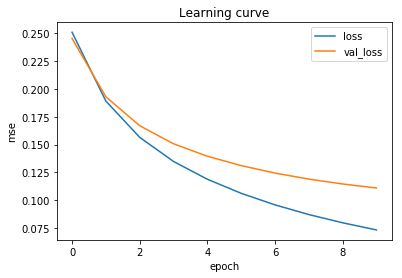

In [34]:
cls1.plot_learning_curve()

### 環境②
- バッチサイズ：10
- エポック数：10
- 隠れ層の数：100
- 初期化方法：Simple
- 活性化関数：Relu
- 最適化方法：SGD

### 考察
- 学習データに対してはエポック数毎にロスが低下しているが、検証データに対しては4エポック以降はロスが上昇している事を確認。環境①ではロスが低下している為、活性化関数をTanhからReluに変更したことが影響を与えている可能性あり。

In [35]:
cls2 = ScratchConv2DNeuralNetrowkClassifier(lr=0.01,\
                                           sigma=0.1,\
                                           batch_size=10,\
                                           n_epochs=10,\
                                           conv_params=conv_params,\
                                           pool_params=pool_params,\
                                           hidden_size=100,\
                                           n_output=10,\
                                           initializer='Sim',\
                                           activater='Relu',\
                                           optimizer='SGD',\
                                           verbose=True)
cls2.fit(X_train, y_train, X_test, y_test)

1epoch目

学習用正解データとの誤差　：　0.1901

検証用正解データとの誤差　：　0.1899

------------------------------------------------
2epoch目

学習用正解データとの誤差　：　0.1432

検証用正解データとの誤差　：　0.1518

------------------------------------------------
3epoch目

学習用正解データとの誤差　：　0.1219

検証用正解データとの誤差　：　0.1368

------------------------------------------------
4epoch目

学習用正解データとの誤差　：　0.1037

検証用正解データとの誤差　：　0.1221

------------------------------------------------
5epoch目

学習用正解データとの誤差　：　0.0913

検証用正解データとの誤差　：　0.1156

------------------------------------------------
6epoch目

学習用正解データとの誤差　：　0.0843

検証用正解データとの誤差　：　0.1159

------------------------------------------------
7epoch目

学習用正解データとの誤差　：　0.0763

検証用正解データとの誤差　：　0.1132

------------------------------------------------
8epoch目

学習用正解データとの誤差　：　0.0709

検証用正解データとの誤差　：　0.1159

------------------------------------------------
9epoch目

学習用正解データとの誤差　：　0.0676

検証用正解データとの誤差　：　0.1165

------------------------------------------------
10epoch目

学習用正解データとの誤差　：　0.0652

検証用正解データとの誤差　：　0.1225

--------

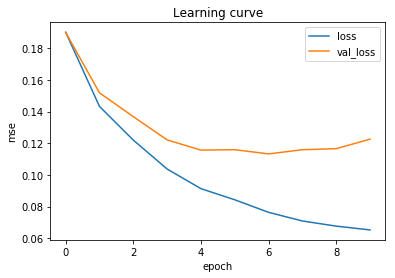

In [36]:
cls2.plot_learning_curve()

### 環境③
- バッチサイズ：10
- エポック数：10
- 隠れ層の数：100
- 初期化方法：Simple
- 活性化関数：Tanh
- 最適化方法：AdaGrad

### 考察
- 学習データ、検証データ共にエポック数毎にロスが低下しており、正常に学習できている事を確認。

In [37]:
cls3 = ScratchConv2DNeuralNetrowkClassifier(lr=0.01,\
                                           sigma=0.1,\
                                           batch_size=10,\
                                           n_epochs=10,\
                                           conv_params=conv_params,\
                                           pool_params=pool_params,\
                                           hidden_size=100,\
                                           n_output=10,\
                                           initializer='Sim',\
                                           activater='Tanh',\
                                           optimizer='AdaGrad',\
                                           verbose=True)
cls3.fit(X_train, y_train, X_test, y_test)

1epoch目

学習用正解データとの誤差　：　0.2325

検証用正解データとの誤差　：　0.2330

------------------------------------------------
2epoch目

学習用正解データとの誤差　：　0.1958

検証用正解データとの誤差　：　0.1999

------------------------------------------------
3epoch目

学習用正解データとの誤差　：　0.1749

検証用正解データとの誤差　：　0.1815

------------------------------------------------
4epoch目

学習用正解データとの誤差　：　0.1604

検証用正解データとの誤差　：　0.1689

------------------------------------------------
5epoch目

学習用正解データとの誤差　：　0.1494

検証用正解データとの誤差　：　0.1596

------------------------------------------------
6epoch目

学習用正解データとの誤差　：　0.1406

検証用正解データとの誤差　：　0.1523

------------------------------------------------
7epoch目

学習用正解データとの誤差　：　0.1334

検証用正解データとの誤差　：　0.1464

------------------------------------------------
8epoch目

学習用正解データとの誤差　：　0.1273

検証用正解データとの誤差　：　0.1414

------------------------------------------------
9epoch目

学習用正解データとの誤差　：　0.1220

検証用正解データとの誤差　：　0.1372

------------------------------------------------
10epoch目

学習用正解データとの誤差　：　0.1173

検証用正解データとの誤差　：　0.1336

--------

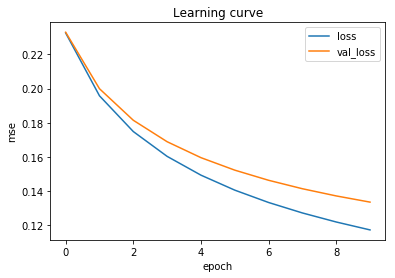

In [62]:
cls3.plot_learning_curve()

## 【問題6】（アドバンス課題）LeNet

CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。

現在では実用的に使われることはありませんが、歴史的に重要なのは1998年のLeNetです。この構造を再現して動かしてみましょう。

[Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)

※上記論文から引用

サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。

- 畳み込み層　出力チャンネル数6、フィルタサイズ5 $\times$ 5、ストライド1
- ReLU
- 最大プーリング
- 畳み込み層　出力チャンネル数16、フィルタサイズ5 $\times$ 5、ストライド1
- ReLU
- 最大プーリング
- 平滑化
- 全結合層　出力ノード数120
- ReLU
- 全結合層　出力ノード数84
- ReLU
- 全結合層　出力ノード数10
- ソフトマックス関数

## 【問題7】（アドバンス課題）有名な画像認識モデルの調査

CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。

どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

参考

[Applications - Keras Documentation](https://keras.io/ja/applications/)

- Xception
- VGG16
- VGG19
- ResNet50
- InceptionV3
- InceptionResNetV2
- MobileNet
- DenseNet
- NASNet
- MobileNetV2

## 【問題8】（アドバンス課題）平均プーリングの作成

平均プーリング層のクラスAveragePool2Dを作成してください。

範囲内の最大値ではなく、平均値を出力とするプーリング層です。

画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

## 【問題9】出力サイズとパラメータ数の計算

CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。

以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

## 出力サイズとパラメータ数を計算するメソッド

In [57]:
class compute():
    '''
    出力サイズとパラメータを計算する関数

    Parameters
    --------------
    H : int
        高さ
    W : int
        幅
    C : int
        入力チャンネル数
    FH : int
        フィルターの高さ
    FW : int
        フィルターの幅
    FN : int
        フィルタ数
    P : int
        パディング
    S : int
        ストライド

    '''
    def __init__(self,H, W, C, FH, FW, FN, P, S):
        self.H = H
        self.W = W
        self.C = C
        self.FH = FH
        self.FW = FW
        self.FN = FN
        self.P = P
        self.S = S
    
    def output_size(self):
    '''
    出力サイズを計算

    Return
    --------------
    out_h : int
        出力データの高さ
    out_w : int
        出力データの幅
    out_c : int
        出力データのチャンネル数
            
    '''
        out_h = int((self.H + 2 * self.P - self.FH) / self.S) + 1
        out_w = int((self.W + 2 * self.P - self.FW) / self.S) + 1
        out_c = self.FN
        return out_h, out_w, out_c
    
    def paramater(self):
    '''
    パラメータ数を計算

    Return
    --------------
    parametor : int
        出力データの高さ
    '''
          
        parameter = self.FH * self.FW * self.C * self.FN + self.FN
        return parameter
    
    def display(self):
    '''
    計算結果を表示

    Return
    --------------
    '''
        out_h, out_w, out_c = self.output_size()
        parameter = self.paramater()
        print('出力サイズ(H, W, C)=({}:{}:{})'.format(out_h, out_w, out_c))
        print('パラメータ数：{}'.format(parameter))

## パターン①

- 入力サイズ : 144 $\times$ 144, 3チャンネル
- フィルタサイズ : 3 $\times$ 3, 6チャンネル(入力データの2倍のフィルタ数の為、出力データのチャンネル数は2)
- ストライド : 1
- パディング : なし

In [58]:
#入力サイズ
H, W, C = (144, 144, 3)

#フィルタサイズ
FH, FW, FN = (3, 3, 2)

#パディング
P = 0

#ストライド
S = 1

com = compute(H, W, C, FH, FW, FN, P, S)
com.display()

出力サイズ(H, W, C)=(142:142:2)
パラメータ数：56


## パターン②

- 入力サイズ : 60 $\times$ 60, 24チャンネル
- フィルタサイズ : 3 $\times$ 3, 24チャンネル, 2フィルタ
- ストライド　: 1
- パディング : なし

In [59]:
#入力サイズ
H, W, C = (60, 60, 24)

#フィルタサイズ
FH, FW, FN = (3, 3, 2)

#パディング
P = 0

#ストライド
S = 1

com = compute(H, W, C, FH, FW, FN, P, S)
com.display()

出力サイズ(H, W, C)=(58:58:2)
パラメータ数：434


## パターン③

- 入力サイズ : 20 $\times$ 20, 10チャンネル
- フィルタサイズ: 3 $\times$ 3, 10チャンネル, 2フィルタ
- ストライド : 2
- パディング : なし

In [60]:
#入力サイズ
H, W, C = (20, 20, 10)

#フィルタサイズ
FH, FW, FN = (3, 3, 2)

#パディング
P = 0

#ストライド
S = 2

com = compute(H, W, C, FH, FW, FN, P, S)
com.display()

出力サイズ(H, W, C)=(9:9:2)
パラメータ数：182


＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

## 【問題10】（アドバンス課題）フィルタサイズに関する調査

畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3 $\times$ 3と1 $\times$ 1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。

- 7 $\times$ 7などの大きめのものではなく、3 $\times$ 3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1 $\times$ 1のフィルタの効果